# Propósito

Este notebook tem como objetivo realizar uma análise exploratória de algumas colunas de interesse das medições dos sensores de qualidade do ar.

O principal objetivo será preencher alguns valores nulos utilizando a função interpolate()

Mas para não enviesar muitos dados preencheremos apenas os valores em que a quantidade de valores nulas no dia semana menor que 7


# Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from scipy.stats import shapiro, anderson, boxcox, kstest, norm
from scipy.special import boxcox1p
from scipy import stats

# Consumindo bases

In [2]:
url_sensor = '/content/drive/MyDrive/TCC/sensores-2011-2021/medicao-sensores.csv'

df_sensor = pd.read_csv(url_sensor, sep=',')

url_estacoes = '/content/drive/MyDrive/TCC/sensores-2011-2021/estacoes.csv'

df_estacoes = pd.read_csv(url_estacoes, sep=',')

In [3]:
df_sensor.columns

Index(['objectid', 'data', 'codnum', 'estação', 'chuva', 'pres', 'rs', 'temp',
       'ur', 'dir_vento', 'vel_vento', 'so2', 'no2', 'hcnm', 'hct', 'ch4',
       'co', 'no', 'nox', 'o3', 'pm10', 'pm2_5', 'lat', 'lon',
       'x_utm_sirgas2000', 'y_utm_sirgas2000'],
      dtype='object')

# Pré-processamento

## Selecionando e criando colunas

In [4]:
#@title Criando coluna nome estacao com base na coluna codnum
df_sensor['nome_estacao'] = df_sensor['codnum'].map(df_estacoes.set_index('codnum')['nome'])

In [5]:
#@title Selecionando as colunas mais relevantes
interest_columns = ['nome_estacao', 'data', 'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5']

df_sensor_interest = df_sensor[interest_columns]

In [6]:
#@title Criando colunas de ano e mês para facilitar a análise temporal
df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%Y/%m/%d %H:%M:%S+00')
df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
df_sensor_interest['ano'] = df_sensor_interest['data'].dt.year
df_sensor_interest['mes'] = df_sensor_interest['data'].dt.month

<ipython-input-6-f9a423e0dd73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%Y/%m/%d %H:%M:%S+00')
<ipython-input-6-f9a423e0dd73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
<ipython-input-6-f9a423e0dd73>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [7]:
#@title Removendo ano de 2011 (Pela falta de alguns poluente) e anos da pandemia
df_sensor_interest_filtered = df_sensor_interest[(df_sensor_interest['ano'] > 2011) & (df_sensor_interest['ano'] < 2020)]

In [8]:
#@title Filtrando por Campo Grande
df_sensor_bangu = df_sensor_interest_filtered[df_sensor_interest_filtered['nome_estacao'] == 'ESTAÇÃO BANGU']

# Tratando colunas de interesse por Estação de monitoriamento


## Estação Bangu
Colunas normalizadas: Chuva, Temperatura, Umidade relativa, CO, NO, NO2, NOx, SO2, O3, PM10

### Chuva

In [9]:
df_sensor_bangu['chuva'].describe()

,chuva
count,67605.000000
mean,0.142624
std,1.304532
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,65.600000


In [10]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_bangu[df_sensor_bangu['chuva'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 1195


In [11]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_bangu['chuva_nulos_no_dia'] = (
    df_sensor_bangu['chuva'].isnull()
    .groupby(df_sensor_bangu['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-11-5692b62f974b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_bangu['chuva_nulos_no_dia'] = (


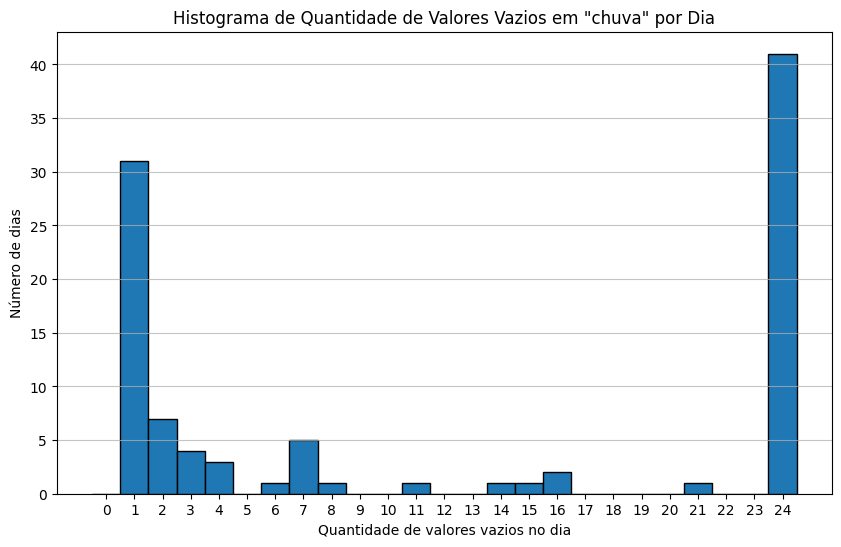

In [12]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_bangu[df_sensor_bangu['chuva_nulos_no_dia'] != 0].groupby('data_formatada')['chuva_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "chuva" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [13]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias)

mask = (df_sensor_bangu['chuva_nulos_no_dia'] <= 6)

num_nulls = df_sensor_bangu[mask]['chuva'].isnull().sum()
df_sensor_bangu.loc[mask, 'chuva'] = df_sensor_bangu[mask]['chuva'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'chuva'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

75 linhas foram preenchidas com interpolate na coluna 'chuva'.
Foram preenchido 6% de dados


In [14]:
df_sensor_bangu['chuva'].describe()

,chuva
count,67680.000000
mean,0.142775
std,1.304330
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,65.600000


### Temperatura

In [15]:
df_sensor_bangu['temp'].describe()

,temp
count,52797.000000
mean,26.720865
std,4.823045
min,14.270000
25%,23.220000
50%,26.100000
75%,29.720000
max,43.470000


In [16]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_bangu[df_sensor_bangu['temp'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 16003


In [17]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_bangu['temp_nulos_no_dia'] = (
    df_sensor_bangu['temp'].isnull()
    .groupby(df_sensor_bangu['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-17-c04df18a8799>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_bangu['temp_nulos_no_dia'] = (


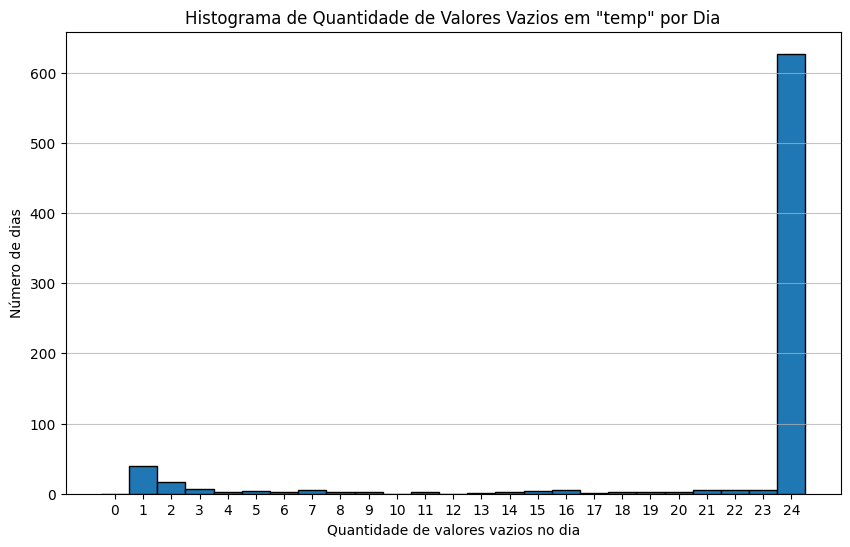

In [18]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_bangu[df_sensor_bangu['temp_nulos_no_dia'] != 0].groupby('data_formatada')['temp_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "temp" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [19]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_bangu['temp_nulos_no_dia'] <= 6)

num_nulls = df_sensor_bangu[mask]['temp'].isnull().sum()
df_sensor_bangu.loc[mask, 'temp'] = df_sensor_bangu[mask]['temp'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'temp'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

142 linhas foram preenchidas com interpolate na coluna 'temp'.
Foram preenchido 1% de dados


In [20]:
df_sensor_bangu['temp'].describe()

,temp
count,52939.000000
mean,26.725394
std,4.822496
min,14.270000
25%,23.220000
50%,26.100000
75%,29.720000
max,43.470000


### Umidade relativa

In [21]:
df_sensor_bangu['ur'].describe()

,ur
count,66626.000000
mean,68.969888
std,18.707722
min,13.080000
25%,55.472500
50%,70.320000
75%,83.270000
max,99.900000


In [22]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_bangu[df_sensor_bangu['ur'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 2174


In [23]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_bangu['ur_nulos_no_dia'] = (
    df_sensor_bangu['ur'].isnull()
    .groupby(df_sensor_bangu['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-23-11350b3a424b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_bangu['ur_nulos_no_dia'] = (


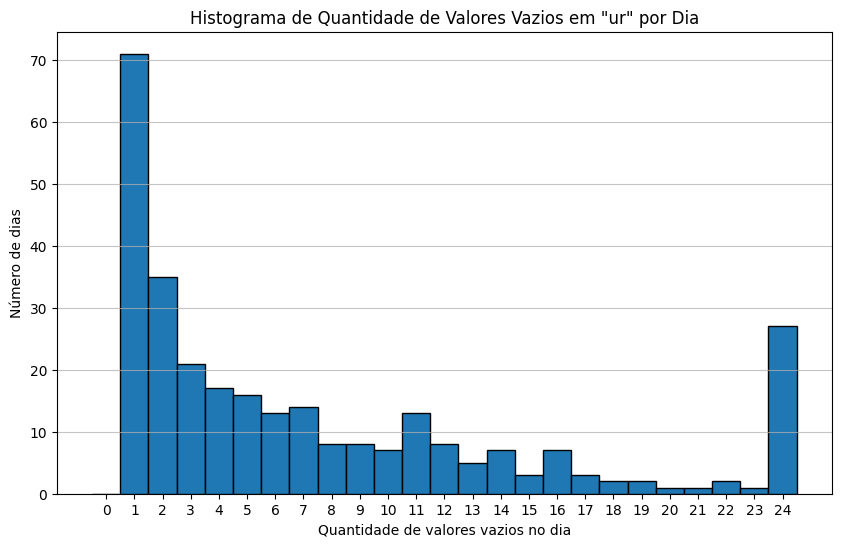

In [24]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_bangu[df_sensor_bangu['ur_nulos_no_dia'] != 0].groupby('data_formatada')['ur_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "ur" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [25]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_bangu['ur_nulos_no_dia'] <= 6)

num_nulls = df_sensor_bangu[mask]['ur'].isnull().sum()
df_sensor_bangu.loc[mask, 'ur'] = df_sensor_bangu[mask]['ur'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'ur'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

430 linhas foram preenchidas com interpolate na coluna 'ur'.
Foram preenchido 20% de dados


In [26]:
df_sensor_bangu['ur'].describe()

,ur
count,67056.000000
mean,69.011183
std,18.727738
min,13.080000
25%,55.480000
50%,70.370000
75%,83.350000
max,99.900000


### Monóxido de carbono

In [27]:
df_sensor_bangu['co'].describe()

,co
count,63264.000000
mean,0.369657
std,0.230286
min,0.000000
25%,0.220000
50%,0.330000
75%,0.460000
max,3.050000


In [28]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_bangu[df_sensor_bangu['co'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 5536


In [29]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_bangu['co_nulos_no_dia'] = (
    df_sensor_bangu['co'].isnull()
    .groupby(df_sensor_bangu['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-29-a84c605dcd17>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_bangu['co_nulos_no_dia'] = (


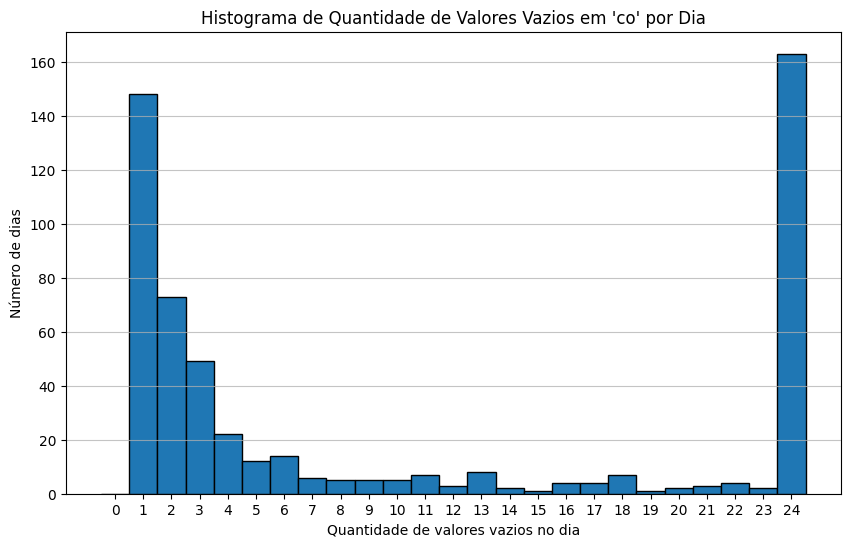

In [30]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_bangu[df_sensor_bangu['co_nulos_no_dia'] != 0].groupby('data_formatada')['co_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'co' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [31]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_bangu['co_nulos_no_dia'] <= 6)

num_nulls = df_sensor_bangu[mask]['co'].isnull().sum()
df_sensor_bangu.loc[mask, 'co'] = df_sensor_bangu[mask]['co'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'co'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

673 linhas foram preenchidas com interpolate na coluna 'co'.
Foram preenchido 12% de dados


In [32]:
df_sensor_bangu['co'].describe()

,co
count,63937.00000
mean,0.36971
std,0.22975
min,0.00000
25%,0.22000
50%,0.33000
75%,0.46000
max,3.05000


### Monóxido de Nitrogênio

In [33]:
df_sensor_bangu['no'].describe()

,no
count,64607.000000
mean,6.345528
std,9.899259
min,0.000000
25%,1.690000
50%,3.240000
75%,6.620000
max,188.230000


In [34]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_bangu[df_sensor_bangu['no'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4193


In [35]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_bangu['no_nulos_no_dia'] = (
    df_sensor_bangu['no'].isnull()
    .groupby(df_sensor_bangu['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-35-8c52a5a4e421>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_bangu['no_nulos_no_dia'] = (


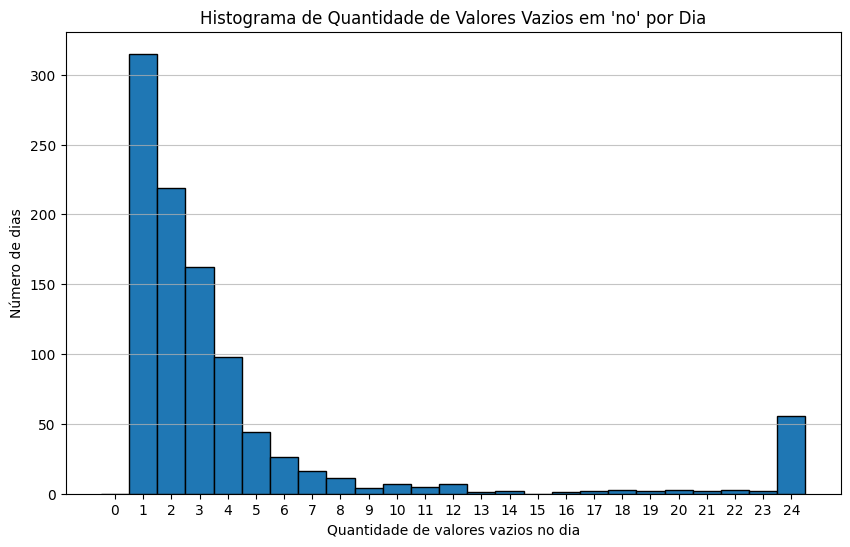

In [36]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_bangu[df_sensor_bangu['no_nulos_no_dia'] != 0].groupby('data_formatada')['no_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [37]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_bangu['no_nulos_no_dia'] <= 6)

num_nulls = df_sensor_bangu[mask]['no'].isnull().sum()
df_sensor_bangu.loc[mask, 'no'] = df_sensor_bangu[mask]['no'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2007 linhas foram preenchidas com interpolate na coluna 'no'.
Foram preenchido 48% de dados


In [38]:
df_sensor_bangu['no'].describe()

,no
count,66614.000000
mean,6.246609
std,9.806278
min,0.000000
25%,1.640000
50%,3.180000
75%,6.520000
max,188.230000


### Dióxido de Nitrogênio

In [39]:
df_sensor_bangu['no2'].describe()

,no2
count,64437.000000
mean,23.245915
std,15.525096
min,0.000000
25%,11.980000
50%,19.640000
75%,30.520000
max,172.880000


In [40]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_bangu[df_sensor_bangu['no2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4363


In [41]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_bangu['no2_nulos_no_dia'] = (
    df_sensor_bangu['no2'].isnull()
    .groupby(df_sensor_bangu['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-41-4c57ed22580f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_bangu['no2_nulos_no_dia'] = (


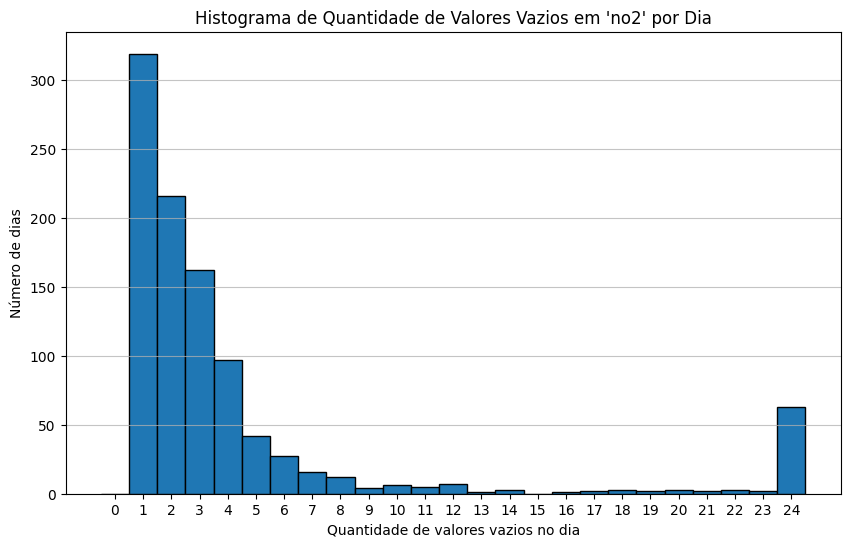

In [42]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_bangu[df_sensor_bangu['no2_nulos_no_dia'] != 0].groupby('data_formatada')['no2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [43]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_bangu['no2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_bangu[mask]['no2'].isnull().sum()
df_sensor_bangu.loc[mask, 'no2'] = df_sensor_bangu[mask]['no2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1997 linhas foram preenchidas com interpolate na coluna 'no2'.
Foram preenchido 46% de dados


In [44]:
df_sensor_bangu['no2'].describe()

,no2
count,66434.000000
mean,23.076209
std,15.466316
min,0.000000
25%,11.880000
50%,19.461667
75%,30.297500
max,172.880000


### Óxido de Nitrogênio

In [45]:
df_sensor_bangu['nox'].describe()

,nox
count,64424.000000
mean,29.584093
std,22.139110
min,0.000000
25%,14.470000
50%,23.420000
75%,37.770000
max,233.650000


In [46]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_bangu[df_sensor_bangu['nox'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4376


In [47]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_bangu['nox_nulos_no_dia'] = (
    df_sensor_bangu['nox'].isnull()
    .groupby(df_sensor_bangu['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-47-e1fd126c342a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_bangu['nox_nulos_no_dia'] = (


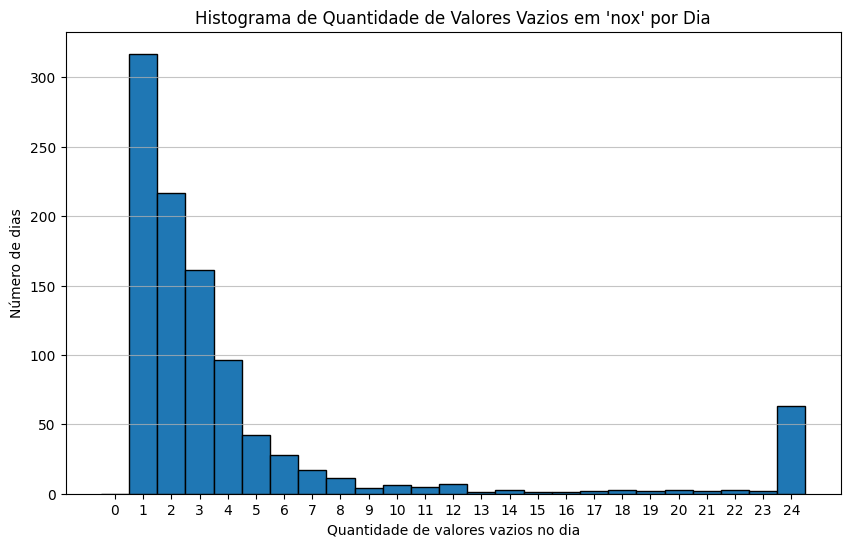

In [48]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_bangu[df_sensor_bangu['nox_nulos_no_dia'] != 0].groupby('data_formatada')['nox_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'nox' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [49]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_bangu['nox_nulos_no_dia'] <= 6)

num_nulls = df_sensor_bangu[mask]['nox'].isnull().sum()
df_sensor_bangu.loc[mask, 'nox'] = df_sensor_bangu[mask]['nox'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'nox'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1996 linhas foram preenchidas com interpolate na coluna 'nox'.
Foram preenchido 46% de dados


In [50]:
df_sensor_bangu['nox'].describe()

,nox
count,66420.000000
mean,29.312567
std,22.011693
min,0.000000
25%,14.310000
50%,23.170000
75%,37.412500
max,233.650000


### Dióxido de Enxofre Campo Grande

In [51]:
df_sensor_bangu['so2'].describe()

,so2
count,61519.000000
mean,3.008616
std,4.225851
min,0.000000
25%,0.520000
50%,2.270000
75%,4.180000
max,221.340000


In [52]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_bangu[df_sensor_bangu['so2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 7281


In [53]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_bangu['so2_nulos_no_dia'] = (
    df_sensor_bangu['so2'].isnull()
    .groupby(df_sensor_bangu['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-53-3ad64c52548a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_bangu['so2_nulos_no_dia'] = (


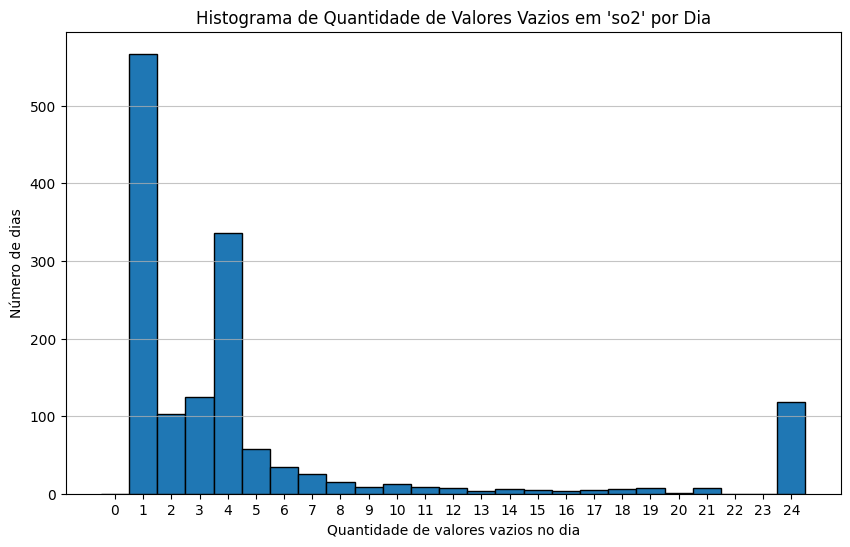

In [54]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_bangu[df_sensor_bangu['so2_nulos_no_dia'] != 0].groupby('data_formatada')['so2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'so2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [55]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_bangu['so2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_bangu[mask]['so2'].isnull().sum()
df_sensor_bangu.loc[mask, 'so2'] = df_sensor_bangu[mask]['so2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'so2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2989 linhas foram preenchidas com interpolate na coluna 'so2'.
Foram preenchido 41% de dados


In [56]:
df_sensor_bangu['so2'].describe()

,so2
count,64507.000000
mean,3.002333
std,4.176098
min,0.000000
25%,0.540000
50%,2.270000
75%,4.170000
max,221.340000


### Ozônio Campo Grande

In [57]:
df_sensor_bangu['o3'].describe()

,o3
count,64708.000000
mean,47.531775
std,37.077824
min,0.000000
25%,19.217500
50%,41.250000
75%,66.780000
max,290.640000


In [58]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_bangu[df_sensor_bangu['o3'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4092


In [59]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_bangu['o3_nulos_no_dia'] = (
    df_sensor_bangu['o3'].isnull()
    .groupby(df_sensor_bangu['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-59-85a5f26cdee5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_bangu['o3_nulos_no_dia'] = (


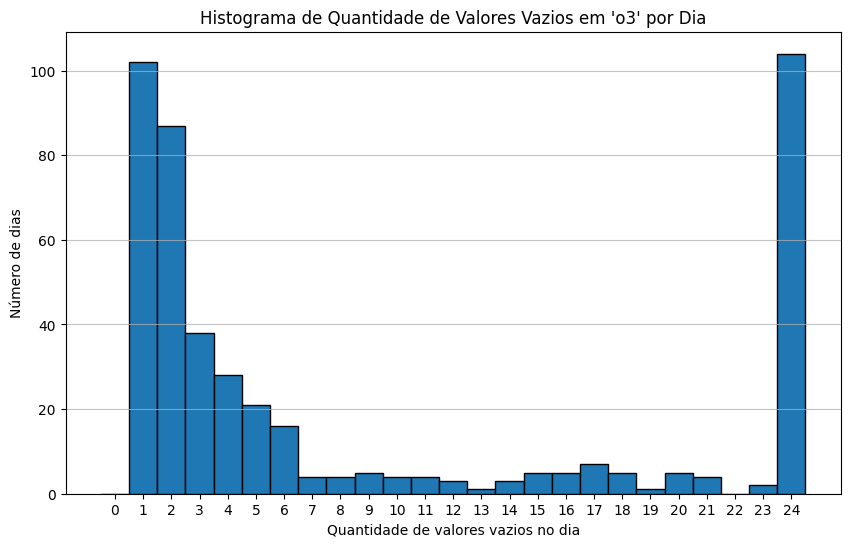

In [60]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_bangu[df_sensor_bangu['o3_nulos_no_dia'] != 0].groupby('data_formatada')['o3_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'o3' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [61]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_bangu['o3_nulos_no_dia'] <= 6)

num_nulls = df_sensor_bangu[mask]['o3'].isnull().sum()
df_sensor_bangu.loc[mask, 'o3'] = df_sensor_bangu[mask]['o3'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'o3'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

703 linhas foram preenchidas com interpolate na coluna 'o3'.
Foram preenchido 17% de dados


In [62]:
df_sensor_bangu['o3'].describe()

,o3
count,65411.000000
mean,47.688255
std,37.049825
min,0.000000
25%,19.400000
50%,41.470000
75%,67.010000
max,290.640000


### PM10 Campo Grande

In [63]:
df_sensor_bangu['pm10'].describe()

,pm10
count,62101.000000
mean,36.375225
std,25.932942
min,0.000000
25%,19.000000
50%,31.000000
75%,47.000000
max,473.000000


In [64]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_bangu[df_sensor_bangu['pm10'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 6699


In [65]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_bangu['pm10_nulos_no_dia'] = (
    df_sensor_bangu['pm10'].isnull()
    .groupby(df_sensor_bangu['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-65-1df09b37e55d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_bangu['pm10_nulos_no_dia'] = (


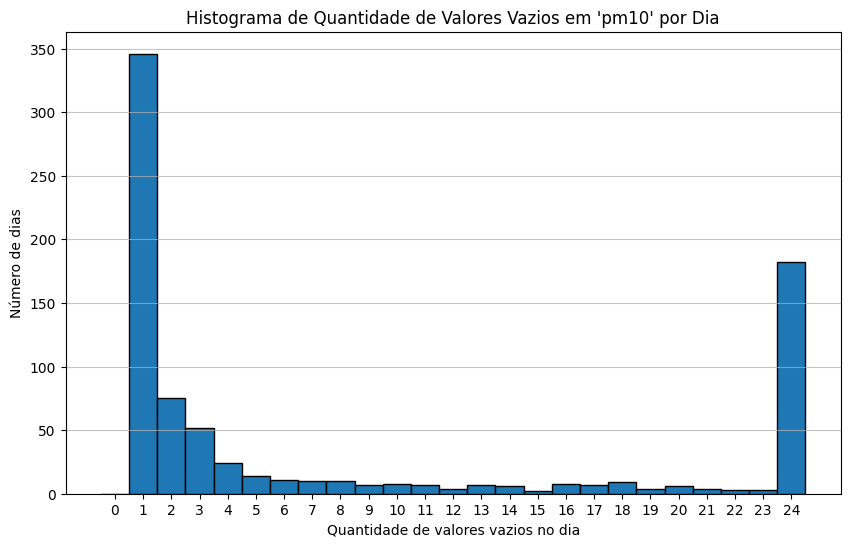

In [66]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_bangu[df_sensor_bangu['pm10_nulos_no_dia'] != 0].groupby('data_formatada')['pm10_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'pm10' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [67]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_bangu['pm10_nulos_no_dia'] <= 6)

num_nulls = df_sensor_bangu[mask]['pm10'].isnull().sum()
df_sensor_bangu.loc[mask, 'pm10'] = df_sensor_bangu[mask]['pm10'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'pm10'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

884 linhas foram preenchidas com interpolate na coluna 'pm10'.
Foram preenchido 13% de dados


In [68]:
df_sensor_bangu['pm10'].describe()

,pm10
count,62985.000000
mean,36.414303
std,25.960695
min,0.000000
25%,19.000000
50%,31.000000
75%,47.000000
max,473.000000


# Gerando CSV de saída com a estação de Campo Grande preenchida


In [69]:
droping_columns = ['chuva_nulos_no_dia', 'temp_nulos_no_dia', 'ur_nulos_no_dia', 'co_nulos_no_dia', 'no_nulos_no_dia', 'no2_nulos_no_dia', 'nox_nulos_no_dia', 'so2_nulos_no_dia', 'o3_nulos_no_dia', 'pm10_nulos_no_dia']

df_sensor_bangu.drop(columns=droping_columns, inplace=True)

<ipython-input-69-d7762321af72>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_bangu.drop(columns=droping_columns, inplace=True)


In [70]:
df_sensor_bangu.to_csv('df_sensor_bangu_preenchido.csv', index=False)